In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Hook 제거하고 직접 구현 (torch size 안맞음)

In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForCausalLM, # SFT 모델을 이용한 응답 생성을 위해 추가
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from peft import PeftModel

# ====================================================================
# 1. 설정: 학습 때와 동일한 설정을 사용해야 합니다.
# ====================================================================

# 1. 불러올 기본 모델 ID (학습 때 사용한 모델)
base_model_id = "unsloth/llama-3.2-1b-instruct-bnb-4bit"

# 2. 저장된 LoRA 어댑터가 있는 폴더 경로
#    학습 스크립트의 'output_dir'에 지정된 경로 아래 'final_reward_adapters' 또는 마지막 체크포인트
adapter_path = "./try_trl/final_reward_adapters_data10000" # trainer.save_model()로 저장한 경로

# 응답 생성을 위한 SFT
sft_adapter_path = "./try_trl/final_sft_adapters"

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ====================================================================
# 2. 보상 모델 및 토크나이저 로딩
# ====================================================================

print("💾 기본 모델과 토크나이저를 로드합니다...")

# 4비트 양자화 설정 (학습 때와 동일)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# 기본 모델 로드 (주의: 아직 어댑터가 적용되지 않은 순수 기본 모델)
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    num_labels=1, # 학습 때와 동일하게 num_labels=1 설정
)

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# ==================== 여기부터 수정 코드를 추가합니다 ====================
print("🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...")

in_features = base_model.score.in_features
new_score_layer = torch.nn.Linear(
    in_features,
    1,
    bias=False,
    dtype=torch.float16 # 모델의 나머지 부분과 맞추기 위해 float16으로 직접 지정
)

# 새로 만든 레이어를 모델의 나머지 부분과 동일한 디바이스(GPU)로 이동시킵니다.
base_model.score = new_score_layer.to(base_model.device)

print("✅ 'score' 레이어 교체 및 디바이스 이동 완료!")
# ======================================================================

# --- LoRA 어댑터 적용 ---
print(f"✅ 기본 모델에 '{adapter_path}'의 어댑터를 적용합니다...")

# PeftModel.from_pretrained를 사용하여 기본 모델에 저장된 어댑터 가중치를 합칩니다.
# 이것이 최종적으로 우리가 사용할 보상 모델입니다.
reward_model = PeftModel.from_pretrained(base_model, adapter_path)

# 모델을 평가 모드로 설정합니다. (Dropout 등 비활성화)
reward_model.eval()

print("🎉 보상 모델 로딩 및 테스트 준비 완료!")

💾 기본 모델과 토크나이저를 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at unsloth/llama-3.2-1b-instruct-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...
✅ 'score' 레이어 교체 및 디바이스 이동 완료!
✅ 기본 모델에 './try_trl/final_reward_adapters_data10000'의 어댑터를 적용합니다...
🎉 보상 모델 로딩 및 테스트 준비 완료!


In [9]:
# ====================================================================
# 3. 응답 생성을 위한 SFT 모델 로드 (수정된 부분)
# ====================================================================
print("\n🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...")
# 1. 기본 CausalLM 모델 로드
sft_base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
)
# 토크나이저는 rm_tokenizer와 동일하므로 별도 로드 필요 없음

# 2. SFT 어댑터 결합
generator_model = PeftModel.from_pretrained(sft_base_model, sft_adapter_path)
generator_model.eval()
print("🎉 SFT 모델 로딩 완료!")


🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


🎉 SFT 모델 로딩 완료!


In [32]:
# ====================================================================
# 4. SFT 모델을 이용한 짧은 응답 / 긴 응답 생성 (수정된 부분)
# ====================================================================
print("\n🔄 SFT 모델을 이용해 짧은 응답 / 중간 응답 / 긴 응답을 생성합니다...")

# max_new_tokens를 각 호출 시 지정하기 위해 파이프라인 생성 시에는 제거합니다.
pipe = pipeline("text-generation", model=generator_model, tokenizer=tokenizer)

analysis_prompt = "Explain the concept of 'machine learning' to a 5-year-old."
num_samples_each_type = 50 # 각 종류별로 50개씩, 총 150개 생성

# --- 짧은 응답 생성 ---
print(f"-> {num_samples_each_type}개의 짧은 응답 생성 중...")
short_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    max_new_tokens=15  # 최대 길이를 10 토큰으로 제한하여 짧은 응답 유도
)
short_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in short_responses_raw]

# --- 중간 응답 생성 ---
print(f"-> {num_samples_each_type}개의 중간 응답 생성 중...")
mid_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    min_new_tokens=20,
    max_new_tokens=40
)
mid_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in mid_responses_raw]

# --- 긴 응답 생성 ---
print(f"-> {num_samples_each_type}개의 긴 응답 생성 중...")
long_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    min_new_tokens=50,   # 최소 길이를 80 토큰으로 보장하여 긴 응답 유도
    max_new_tokens=100 # 최대 길이를 150 토큰으로 확장
)
long_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in long_responses_raw]


# --- 결과 합치기 ---
response_texts = short_response_texts + mid_response_texts + long_response_texts
# 생성된 응답에 길이를 표시하는 메타데이터를 추가하면 분석이 더 용이합니다.
response_metadata = \
    [{"text": r, "length_type": "short"} for r in short_response_texts] + \
    [{"text": r, "length_type": "mid"} for r in mid_response_texts] + \
    [{"text": r, "length_type": "long"} for r in long_response_texts]

print(f"✅ 총 {len(response_texts)}개의 다양한 응답 생성 완료! (짧은 응답 {len(short_response_texts)}개, 중간 응답 {len(mid_response_texts)}, 긴 응답 {len(long_response_texts)}개)")

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo


🔄 SFT 모델을 이용해 짧은 응답 / 중간 응답 / 긴 응답을 생성합니다...
-> 50개의 짧은 응답 생성 중...
-> 50개의 중간 응답 생성 중...
-> 50개의 긴 응답 생성 중...
✅ 총 150개의 다양한 응답 생성 완료! (짧은 응답 50개, 중간 응답 50, 긴 응답 50개)


In [33]:
response_texts

['Imagine you have a toy box full of different toys. Some toys are',
 "Imagine you're playing a game with your friend.\n\nHey there, little friend",
 'Imagine you have a toy box full of different colored balls. You want',
 "Imagine you're talking to your mom.\n\nHey Mom, what does'machine",
 'Imagine you have a toy box filled with toys. You can choose one',
 'Imagine you have a toy box full of toys. You can see all',
 'Imagine you are trying to find your way home.  You can ask',
 'Imagine you have a toy box with lots of toys inside. You want',
 'Imagine you have a toy box full of different colored balls. You can',
 'Imagine you have a toy box. Every time you take something out of',
 'Imagine you have a toy box with lots of different toys inside. You',
 'Imagine you have a toy box with lots of different toys inside. Each',
 'Imagine you have a toy box filled with different toys. You want to',
 'Machine learning is a way that computers can get smarter and more accurate over',
 'Imagine y

In [34]:
# ====================================================================
# 5. 새로운 보상 점수 계산 함수 (핵심 수정 사항)
# ====================================================================

def get_reward_score_and_features(model, tokenizer, prompt, response):
    """
    수동 Pooling을 포함한 새로운 보상 점수 계산 함수
    """
    text = prompt + tokenizer.eos_token + response
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        # 1. 모델을 직접 호출하며, 'output_hidden_states=True'를 전달합니다.
        #    이 한 번의 호출로 점수(logits)와 중간 피처(hidden_states)를 모두 얻습니다.
        outputs = model(**inputs, output_hidden_states=True)

        # 2. 최종 점수는 outputs.logits에서 바로 얻을 수 있습니다.
        score = outputs.logits[0].item()

        # # 3. 분석용 피처를 추출합니다.
        # #    outputs.hidden_states는 모든 레이어의 은닉 상태 튜플입니다.
        # all_hidden_states = outputs.hidden_states
        # #    튜플의 마지막 요소가 마지막 레이어의 은닉 상태 시퀀스입니다.
        # last_hidden_states = all_hidden_states[-1] # shape: [1, sequence_length, 2048]
        
        # 4. (수동 Pooling) 마지막 토큰의 은닉 상태를 선택합니다.
        # pooled_features = last_hidden_states[:, -1, :] # shape: [1, 2048]
        pooled_features = outputs.hidden_states[-1][:, -1, :].cpu().numpy()
        
        # 5. 분석을 위해 고정 크기의 피처 벡터를 저장합니다.
        # analyzed_features[response_key] = pooled_features.detach().clone()
        
    return score, pooled_features

In [35]:
print("\n🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...")
analysis_data = []
for i, response in enumerate(response_texts):
    score, features = get_reward_score_and_features(reward_model, tokenizer, analysis_prompt, response)
    analysis_data.append({"response": response, "score": score, "features": features.flatten()})

df = pd.DataFrame(analysis_data)
print("✅ 추출 완료!")


🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...
✅ 추출 완료!


In [36]:
df['response_length'] = df['response'].apply(lambda x: len(x.split()))
df

,response,score,features,response_length
0,Imagine you have a toy box full of different t...,-1.764648,"[1.215, 1.65, 3.357, -0.4026, -0.0656, -1.797,...",13
1,Imagine you're playing a game with your friend...,0.052612,"[0.515, 1.089, 1.679, 0.3113, 2.557, -1.091, 1...",12
2,Imagine you have a toy box full of different c...,-0.149048,"[-1.465, 4.6, 1.345, -0.5654, 2.312, -0.1221, ...",13
3,Imagine you're talking to your mom.\n\nHey Mom...,0.134277,"[-2.705, 4.26, 0.9175, -0.3442, -0.3909, -0.76...",10
4,Imagine you have a toy box filled with toys. Y...,0.691895,"[-1.627, 1.734, 0.391, -0.2035, 1.3125, -0.239...",13
...,...,...,...,...
145,Imagine you're at a playground and you're buil...,-0.818359,"[-0.867, 1.878, -1.538, -1.164, -1.58, -0.2876...",84
146,Imagine you're sitting in a classroom and a te...,0.181030,"[-2.918, 4.008, 0.4985, 2.652, -2.299, -1.956,...",80
147,Imagine you have a toy box filled with all you...,-0.692871,"[0.7407, 4.457, 2.016, -0.2844, 0.9854, -1.119...",88
148,Imagine you have a toy box full of blocks. You...,0.385498,"[0.2242, 3.168, -1.389, -1.727, 3.71, 1.16, 2....",89


📊 'score'와 'response_length' 간의 상관관계를 분석합니다...

--- 분석 결과 ---
점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: -0.0537
해석: 상관관계가 거의 없습니다. 모델이 응답 길이에 크게 영향을 받지 않는 것으로 보입니다.

🎨 분석 결과를 시각화합니다...
✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.


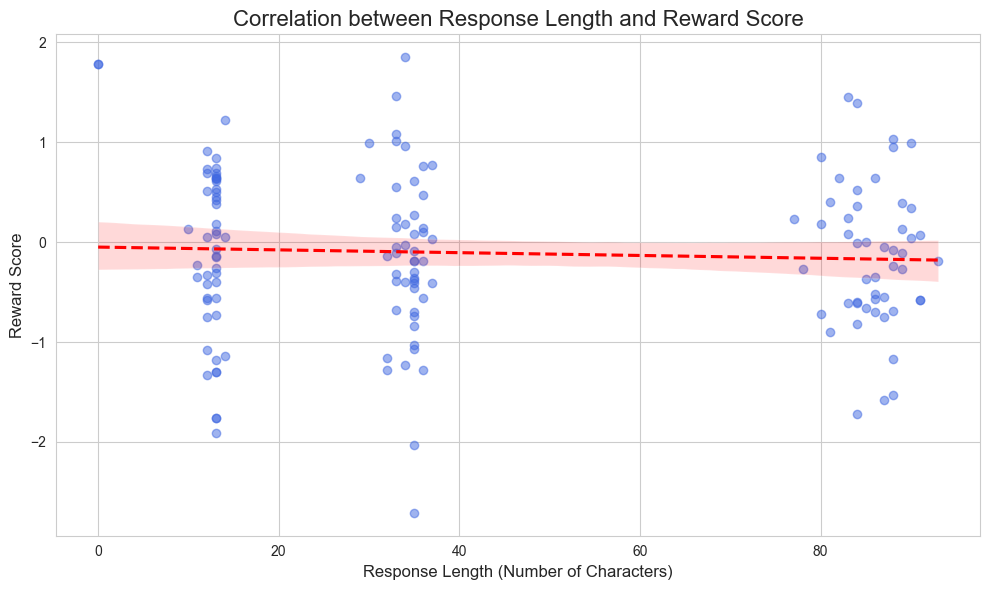

: 

In [ ]:
# --- 1. 피어슨 상관계수 계산 ---
print("📊 'score'와 'response_length' 간의 상관관계를 분석합니다...")

# .corr() 메소드를 사용하여 두 컬럼 간의 피어슨 상관계수를 계산합니다.
correlation = df['score'].corr(df['response_length'])

print("\n--- 분석 결과 ---")
print(f"점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: {correlation:.4f}")

# 상관계수 값에 대한 해석을 덧붙입니다.
if correlation > 0.5:
    print("해석: 강한 양의 상관관계가 있습니다. 모델이 긴 응답에 높은 점수를 주는 경향이 매우 강합니다. (길이 편향 의심)")
elif correlation > 0.2:
    print("해석: 약한 양의 상관관계가 있습니다. 모델이 긴 응답에 점수를 더 주는 경향이 있습니다.")
elif correlation < -0.5:
    print("해석: 강한 음의 상관관계가 있습니다. 모델이 짧은 응답에 높은 점수를 주는 경향이 매우 강합니다.")
elif correlation < -0.2:
    print("해석: 약한 음의 상관관계가 있습니다. 모델이 짧은 응답에 점수를 더 주는 경향이 있습니다.")
else:
    print("해석: 상관관계가 거의 없습니다. 모델이 응답 길이에 크게 영향을 받지 않는 것으로 보입니다.")


# --- 2. 산점도(Scatter Plot) 및 회귀선 시각화 ---

print("\n🎨 분석 결과를 시각화합니다...")

plt.figure(figsize=(10, 6))

# seaborn의 regplot을 사용하면 산점도와 회귀선을 한 번에 그릴 수 있습니다.
sns.regplot(
    data=df,
    x='response_length',
    y='score',
    scatter_kws={'alpha':0.5, 'color':'royalblue'}, # 점에 대한 스타일
    line_kws={'color':'red', 'linestyle':'--'}      # 회귀선에 대한 스타일
)

plt.title('Correlation between Response Length and Reward Score', fontsize=16)
plt.xlabel('Response Length (Number of Characters)', fontsize=12)
plt.ylabel('Reward Score', fontsize=12)
plt.grid(True)
plt.tight_layout()

# 생성된 그래프를 이미지 파일로 저장
plt.savefig("score_vs_length_correlation.png")
print("✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.")


## 분석

In [38]:
# --- 1. 'features' 컬럼을 2048개의 개별 컬럼으로 확장 ---

print("🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...")

# .tolist()를 사용하면 리스트/배열로 구성된 컬럼을 효율적으로 데이터프레임으로 변환 가능
features_expanded_df = pd.DataFrame(df['features'].tolist(), index=df.index)

# 각 컬럼에 'feature_0', 'feature_1', ... 과 같이 이름을 붙여줍니다.
features_expanded_df.columns = [f'feature_{i}' for i in range(features_expanded_df.shape[1])]

# 기존 df에서 'features' 컬럼을 제외하고, 확장된 피처 df를 옆으로 붙입니다.
df_analyzable = pd.concat([df.drop('features', axis=1), features_expanded_df], axis=1)

print("✅ 피처 확장 완료! 분석용 데이터프레임 샘플:")
# 이제 각 feature가 개별 컬럼으로 들어간 것을 확인할 수 있습니다.
print(df_analyzable.head())

🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...
✅ 피처 확장 완료! 분석용 데이터프레임 샘플:
                                            response     score  \
0  Imagine you have a toy box full of different t... -1.764648   
1  Imagine you're playing a game with your friend...  0.052612   
2  Imagine you have a toy box full of different c... -0.149048   
3  Imagine you're talking to your mom.\n\nHey Mom...  0.134277   
4  Imagine you have a toy box filled with toys. Y...  0.691895   

   response_length  feature_0  feature_1  feature_2  feature_3  feature_4  \
0               13   1.214844   1.650391   3.357422  -0.402588  -0.065613   
1               12   0.515137   1.088867   1.678711   0.311279   2.556641   
2               13  -1.464844   4.601562   1.344727  -0.565430   2.312500   
3               10  -2.705078   4.261719   0.917480  -0.344238  -0.390869   
4               13  -1.626953   1.734375   0.391113  -0.203491   1.312500   

   feature_5  feature_6  ...  feature_2038  feature_2039  feature_204

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [39]:
# --- 2. 각 피처와 보상 점수 간의 상관관계 분석 ---

print("\n📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...")

# 'score' 컬럼과 'feature_*' 컬럼들 간의 상관관계만 계산
feature_columns = [col for col in df_analyzable if col.startswith('feature_')]
correlations = df_analyzable[feature_columns].corrwith(df_analyzable['score'])
correlations = correlations.sort_values(ascending=False)

print("\n--- 상관관계 분석 결과 ---")
print("\n[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]")
print(correlations.head(10))

print("\n[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]")
print(correlations.tail(10))


📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...

--- 상관관계 분석 결과 ---

[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]
feature_1307    0.457094
feature_1799    0.442100
feature_1237    0.406494
feature_617     0.403726
feature_1005    0.399356
feature_868     0.396059
feature_348     0.392104
feature_899     0.385008
feature_1023    0.383420
feature_1804    0.379419
dtype: float64

[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]
feature_795    -0.385033
feature_693    -0.388056
feature_1093   -0.389226
feature_531    -0.394603
feature_445    -0.405379
feature_1928   -0.406412
feature_1947   -0.417418
feature_282    -0.425148
feature_1281   -0.448944
feature_1232   -0.468448
dtype: float64


/tmp/ipykernel_2122679/2969119911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")



✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.


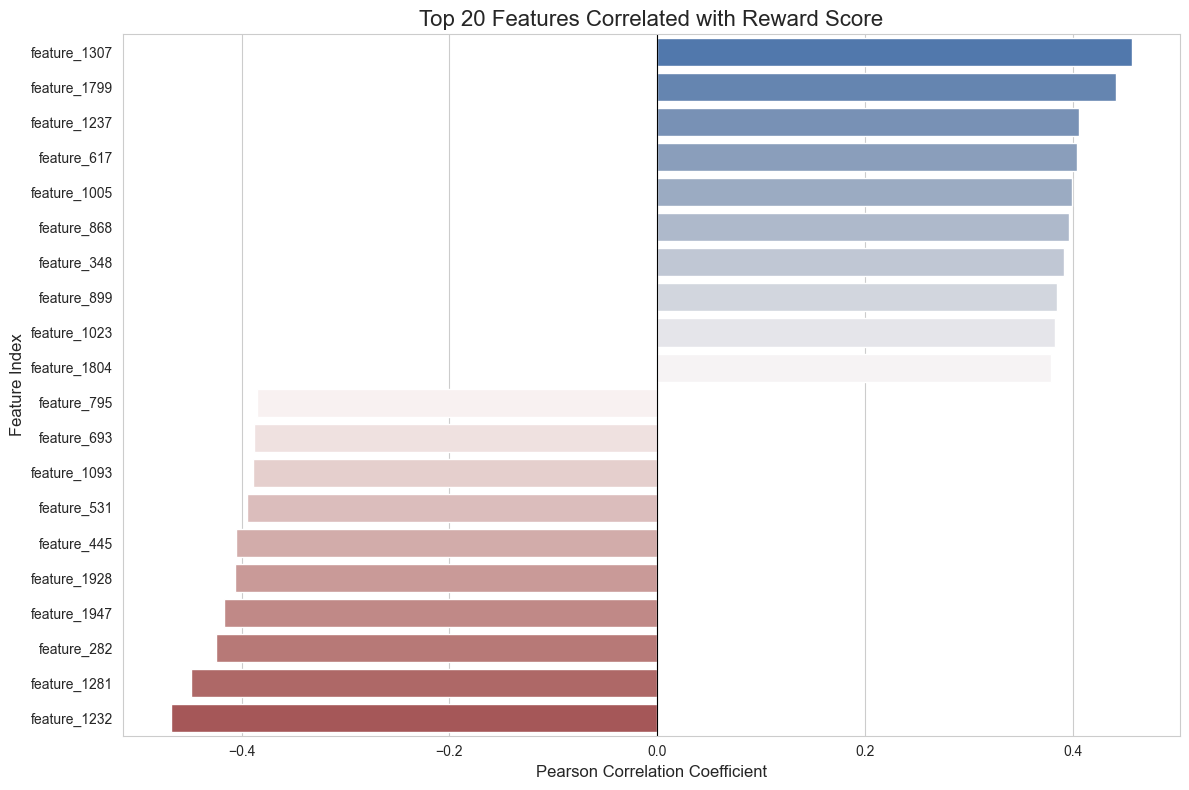

In [40]:
# --- 3. 상관관계 시각화 ---

top_n = 10
top_positive_corr = correlations.head(top_n)
top_negative_corr = correlations.tail(top_n)
top_correlations = pd.concat([top_positive_corr, top_negative_corr])

plt.figure(figsize=(12, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")
plt.title(f"Top {top_n*2} Features Correlated with Reward Score", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.ylabel("Feature Index", fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig("reward_feature_correlation.png")
print("\n✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.")

In [41]:
# --- 4. 심층 분석: 상관관계 높은 피처와 텍스트 연결 ---
# (이전 답변과 동일한, 가장 중요한 분석 파트)

print("\n🔍 가장 상관관계가 높은 피처를 활성화시키는 텍스트를 분석합니다...")

# 가장 상관계수가 높은 피처의 이름 (예: 'feature_512')
top_feature_name = correlations.index[0]
print(f"\n가장 높은 양의 상관관계를 가진 피처: '{top_feature_name}' (상관계수: {correlations.iloc[0]:.4f})")
print("이 피처를 가장 강하게 활성화시킨 응답 Top 3:")

# 해당 피처의 값이 가장 큰 순서대로 정렬하여 상위 3개 응답 출력
top_activating_responses = df_analyzable.sort_values(by=top_feature_name, ascending=False).head(3)
for i, row in top_activating_responses.iterrows():
    print(f"  - (점수: {row['score']:.2f}) \"{row['response'][:100]}...\"")


🔍 가장 상관관계가 높은 피처를 활성화시키는 텍스트를 분석합니다...

가장 높은 양의 상관관계를 가진 피처: 'feature_1307' (상관계수: 0.4571)
이 피처를 가장 강하게 활성화시킨 응답 Top 3:
  - (점수: 0.05) "Imagine you're playing a game with your friend.

Hey there, little friend..."
  - (점수: 1.01) "Imagine you have a lemonade stand. You make lemonade and you sell it to people who walk by. You don'..."
  - (점수: -0.19) "Hey little one, do you know how computers can help us solve problems? Like, they can help us find th..."
